In [1]:
import sqlite3
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import arserate as arse

from sklearn.metrics import confusion_matrix, classification_report

## Data prep

In [2]:
db_path = '../db_files/ratings.db'  # path to data

In [3]:
conn = sqlite3.connect(db_path)  # open connection to db
# construct query to get ratings data
query_data = """SELECT user_ratings.userratingID, user_ratings.playerID, games.gameID,games.wld, user_ratings.userrating 
FROM user_ratings INNER JOIN games ON user_ratings.gameID=games.gameID;"""
df_data = pd.read_sql_query(query_data, conn)  # read data from query to df
conn.close()  # close db connection

In [4]:
grouped = df_data.groupby(['gameID','wld','userrating']).size().reset_index().rename(columns={0:'counts'})
grouped.head()

,gameID,wld,userrating,counts
0,1,win,7,2
1,1,win,7.5,3
2,1,win,8,5
3,1,win,8.5,1
4,1,win,9,3


In [5]:
ml_target_group = grouped.groupby(['gameID','wld']).size().reset_index().drop(labels=[0],axis=1).set_index('gameID')
ml_target = ml_target_group['wld']
ml_target.head()

gameID
1     win
2     win
3     win
4     win
5    draw
Name: wld, dtype: object

In [6]:
ml_data = grouped.pivot(index='gameID', columns='userrating', values='counts').drop(labels='NA', axis=1).fillna(0.0)
print(ml_data.shape)
ml_data.head(10)

(228, 19)


userrating,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0
gameID,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,5.0,1.0,3.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,5.0,2.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,7.0,0.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,8.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0
7,2.0,1.0,3.0,2.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,4.0,1.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0


## Define training and target data

In [7]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(ml_data, ml_target, random_state=42)

# ml_train_data = ml_data.iloc[:-30]
# ml_train_target = ml_target.iloc[:-30]
# ml_test_data = ml_data.iloc[-30:]
# ml_test_target = ml_target.iloc[-30:]

## Multinomial Naive Bayes Classification


In [8]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(Xtrain, ytrain)

labels = model.predict(Xtest)

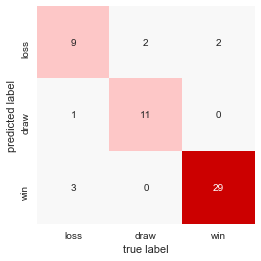

In [9]:
mat = confusion_matrix(ytest, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap=arse.white2red(),
            xticklabels=ytrain.unique(), yticklabels=ytrain.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

## Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [11]:
print(classification_report(ypred, ytest))

             precision    recall  f1-score   support

       draw       0.23      0.43      0.30         7
       loss       0.85      0.79      0.81        14
        win       0.94      0.81      0.87        36

avg / total       0.83      0.75      0.78        57



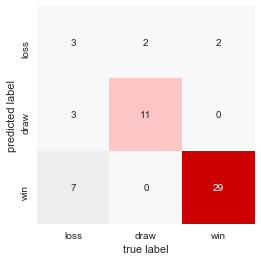

In [12]:
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap=arse.white2red(),
           xticklabels=ytrain.unique(), yticklabels=ytrain.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');